In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# for reading and displaying images
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d, LogSoftmax
from torch.optim import Adam, SGD

# torchvision for pre-trained models
from torchvision import models

In [2]:
train = pd.read_csv('emergency_vs_non-emergency_dataset/emergency_train.csv')
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [3]:
# loading training images
train_img = []
for img_name in tqdm(train['image_names']):
    # defining the image path
    image_path = 'emergency_vs_non-emergency_dataset/images/' + img_name
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
train_x.shape

100%|█████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:15<00:00, 106.95it/s]


(1646, 224, 224, 3)

It is an Emergency vehicle


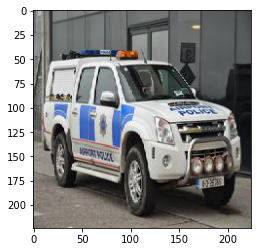

In [4]:
# Exploring the data
index = 10
plt.imshow(train_x[index])
if (train['emergency_or_not'][index] == 1):
    print('It is an Emergency vehicle')
else:
    print('It is a Non-Emergency vehicle')

In [5]:
# defining the target
train_y = train['emergency_or_not'].values

In [6]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((1481, 224, 224, 3), (1481,)), ((165, 224, 224, 3), (165,)))

In [7]:
# converting training images into torch format
train_x = train_x.reshape(1481, 3, 224, 224)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([1481, 3, 224, 224]), torch.Size([1481]))

In [8]:
val_x = val_x.reshape(165, 3, 224, 224)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([165, 3, 224, 224]), torch.Size([165]))

In [9]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(8 * 56 * 56, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [10]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=25088, out_features=2, bias=True)
  )
)


In [11]:
# batch size of the model
batch_size = 128

# number of epochs to train the model
n_epochs = 15

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(train_x.size()[0])

    training_loss = []
    for i in tqdm(range(0,train_x.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = train_x[indices], train_y[indices]
        batch_y = batch_y.long()
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.62it/s]

epoch: 	 1 	 training loss: 	 0.8676542192697525


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.26it/s]

epoch: 	 2 	 training loss: 	 0.728452612956365


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.27it/s]

epoch: 	 3 	 training loss: 	 0.669132187962532


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.50it/s]

epoch: 	 4 	 training loss: 	 0.5861136217912039


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.00it/s]

epoch: 	 5 	 training loss: 	 0.5629342546065649


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.26it/s]

epoch: 	 6 	 training loss: 	 0.5450000564257304


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.39it/s]

epoch: 	 7 	 training loss: 	 0.522984060148398


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 15.04it/s]

epoch: 	 8 	 training loss: 	 0.5111812998851141


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 14.93it/s]

epoch: 	 9 	 training loss: 	 0.49148231248060864


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.26it/s]

epoch: 	 10 	 training loss: 	 0.46415675183137256


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.39it/s]

epoch: 	 11 	 training loss: 	 0.4573763484756152


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.13it/s]

epoch: 	 12 	 training loss: 	 0.4397101054588954


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.26it/s]

epoch: 	 13 	 training loss: 	 0.4284277434150378


 17%|█████████████▊                                                                     | 2/12 [00:00<00:00, 16.33it/s]

epoch: 	 14 	 training loss: 	 0.4054829900463422


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 14.35it/s]

epoch: 	 15 	 training loss: 	 0.3914840643604596


In [12]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(train_x.size()[0])
for i in tqdm(range(0,train_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = train_x[indices], train_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 27.41it/s]

training accuracy: 	 0.875142694063927


In [13]:
# prediction for validation set
prediction_val = []
target_val = []
permutation = torch.randperm(val_x.size()[0])
for i in tqdm(range(0,val_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = val_x[indices], val_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 41.67it/s]

validation accuracy: 	 0.6890836148648649


In [14]:
# Using pretrained vgg16 model for transfer learning

In [15]:
# loading the pretrained model
model = models.vgg16_bn(pretrained=True)

In [16]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [17]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [18]:
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()

In [19]:
# Add on classifier
model.classifier[6] = Sequential(
                      Linear(4096, 2)).cuda()
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [20]:
# batch_size
batch_size = 128

# extracting features for train data
data_x = []
label_x = []

inputs,labels = train_x, train_y

for i in tqdm(range(int(train_x.shape[0]/batch_size)+1)):
    input_data = inputs[i*batch_size:(i+1)*batch_size]
    label_data = labels[i*batch_size:(i+1)*batch_size]
    input_data , label_data = Variable(input_data.cuda()),Variable(label_data.cuda())
    x = model.features(input_data)
    data_x.extend(x.data.cpu().numpy())
    label_x.extend(label_data.data.cpu().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.23it/s]


In [21]:
# extracting features for validation data
data_y = []
label_y = []

inputs,labels = val_x, val_y

for i in tqdm(range(int(val_x.shape[0]/batch_size)+1)):
    input_data = inputs[i*batch_size:(i+1)*batch_size]
    label_data = labels[i*batch_size:(i+1)*batch_size]
    input_data , label_data = Variable(input_data.cuda()),Variable(label_data.cuda())
    x = model.features(input_data)
    data_y.extend(x.data.cpu().numpy())
    label_y.extend(label_data.data.cpu().numpy())


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.75it/s]


In [22]:
# converting the features into torch format
x_train  = torch.from_numpy(np.array(data_x))
x_train = x_train.view(x_train.size(0), -1)
y_train  = torch.from_numpy(np.array(label_x))
x_val  = torch.from_numpy(np.array(data_y))
x_val = x_val.view(x_val.size(0), -1)
y_val  = torch.from_numpy(np.array(label_y))

In [23]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0005)

In [24]:
# batch size
batch_size = 128

# number of epochs to train the model
n_epochs = 30

for epoch in tqdm(range(1, n_epochs+1)):

    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(x_train.size()[0])

    training_loss = []
    for i in range(0,x_train.size()[0], batch_size):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        batch_y = batch_y.long()
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model.classifier(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)


  3%|██▊                                                                                | 1/30 [00:00<00:11,  2.50it/s]

epoch: 	 1 	 training loss: 	 0.6022957414388657


  7%|█████▌                                                                             | 2/30 [00:00<00:11,  2.50it/s]

epoch: 	 2 	 training loss: 	 0.49782367795705795


 10%|████████▎                                                                          | 3/30 [00:01<00:11,  2.35it/s]

epoch: 	 3 	 training loss: 	 0.48400093615055084


 13%|███████████                                                                        | 4/30 [00:01<00:10,  2.39it/s]

epoch: 	 4 	 training loss: 	 0.4525503491361936


 17%|█████████████▊                                                                     | 5/30 [00:02<00:10,  2.36it/s]

epoch: 	 5 	 training loss: 	 0.4450768282016118


 20%|████████████████▌                                                                  | 6/30 [00:02<00:10,  2.28it/s]

epoch: 	 6 	 training loss: 	 0.43551255762577057


 23%|███████████████████▎                                                               | 7/30 [00:02<00:09,  2.34it/s]

epoch: 	 7 	 training loss: 	 0.4134526749451955


 27%|██████████████████████▏                                                            | 8/30 [00:03<00:09,  2.39it/s]

epoch: 	 8 	 training loss: 	 0.4083680311838786


 30%|████████████████████████▉                                                          | 9/30 [00:03<00:08,  2.43it/s]

epoch: 	 9 	 training loss: 	 0.40862473597129184


 33%|███████████████████████████▎                                                      | 10/30 [00:04<00:07,  2.50it/s]

epoch: 	 10 	 training loss: 	 0.40447773039340973


 37%|██████████████████████████████                                                    | 11/30 [00:04<00:07,  2.55it/s]

epoch: 	 11 	 training loss: 	 0.3969754601518313


 40%|████████████████████████████████▊                                                 | 12/30 [00:04<00:06,  2.59it/s]

epoch: 	 12 	 training loss: 	 0.3888336916764577


 43%|███████████████████████████████████▌                                              | 13/30 [00:05<00:06,  2.60it/s]

epoch: 	 13 	 training loss: 	 0.38470690449078876


 47%|██████████████████████████████████████▎                                           | 14/30 [00:05<00:06,  2.61it/s]

epoch: 	 14 	 training loss: 	 0.38328395287195843


 50%|█████████████████████████████████████████                                         | 15/30 [00:06<00:05,  2.62it/s]

epoch: 	 15 	 training loss: 	 0.388242540260156


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:06<00:05,  2.59it/s]

epoch: 	 16 	 training loss: 	 0.37267223248879117


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:06<00:04,  2.61it/s]

epoch: 	 17 	 training loss: 	 0.3702034577727318


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:07<00:04,  2.63it/s]

epoch: 	 18 	 training loss: 	 0.3649597341815631


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:07<00:04,  2.60it/s]

epoch: 	 19 	 training loss: 	 0.3772786855697632


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:07<00:03,  2.62it/s]

epoch: 	 20 	 training loss: 	 0.3629402096072833


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:08<00:03,  2.63it/s]

epoch: 	 21 	 training loss: 	 0.35943475117286044


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:08<00:03,  2.65it/s]

epoch: 	 22 	 training loss: 	 0.35877904792626697


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:09<00:02,  2.62it/s]

epoch: 	 23 	 training loss: 	 0.364681934316953


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:09<00:02,  2.63it/s]

epoch: 	 24 	 training loss: 	 0.3580886994798978


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:09<00:01,  2.65it/s]

epoch: 	 25 	 training loss: 	 0.35074379046758014


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:10<00:01,  2.65it/s]

epoch: 	 26 	 training loss: 	 0.3657493069767952


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:10<00:01,  2.66it/s]

epoch: 	 27 	 training loss: 	 0.34397338330745697


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:10<00:00,  2.67it/s]

epoch: 	 28 	 training loss: 	 0.33627191185951233


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:11<00:00,  2.67it/s]

epoch: 	 29 	 training loss: 	 0.3630908603469531


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.56it/s]

epoch: 	 30 	 training loss: 	 0.34081998964150745


In [25]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(x_train.size()[0])
for i in tqdm(range(0,x_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.38it/s]

training accuracy: 	 0.8349386415525114


In [26]:
# prediction for validation set
prediction_val = []
target_val = []
permutation = torch.randperm(x_val.size()[0])
for i in tqdm(range(0,x_val.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_val[indices], y_val[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.28it/s]

validation accuracy: 	 0.7885346283783784


In [27]:
# Use resnet18 model for transfer learning

In [28]:
# loading the pretrained resnet18 model
model = models.resnet18(pretrained=True)

In [29]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [30]:
#Classifier architecture to put on top of resnet18
from collections import OrderedDict
fc = Sequential(OrderedDict([
    ('fc1', Linear(512,1000)),
    ('relu1', ReLU()),
    ('fc2', Linear(1000,4096)),
    ('relu2',ReLU()),
    ('fc3', Linear(4096, 2)),
    ('output', LogSoftmax(dim=1))
]))

model.fc = fc

In [31]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)

In [33]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [34]:
# batch size of the model
batch_size = 128

# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(train_x.size()[0])

    training_loss = []
    for i in tqdm(range(0,train_x.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = train_x[indices], train_y[indices]
        batch_y = batch_y.long()
        print(batch_x.shape, batch_y.shape)
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.54it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 17%|█████████████▊                                                                     | 2/12 [00:00<00:01,  6.55it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.49it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:01,  6.46it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.47it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:00<00:00,  6.48it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.52it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:01<00:00,  6.31it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.38it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:01<00:00,  6.44it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.48it/s]

torch.Size([73, 3, 224, 224]) torch.Size([73])


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

epoch: 	 1 	 training loss: 	 0.7476371874411901
torch.Size([128, 3, 224, 224]) torch.Size([128])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.54it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 17%|█████████████▊                                                                     | 2/12 [00:00<00:01,  6.44it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.33it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:01,  6.25it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.17it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:00<00:00,  6.13it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.11it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:01<00:00,  6.06it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.04it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:01<00:00,  6.08it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.13it/s]

torch.Size([73, 3, 224, 224]) torch.Size([73])


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

epoch: 	 2 	 training loss: 	 0.5636933992306391
torch.Size([128, 3, 224, 224]) torch.Size([128])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  5.92it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  5.41it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 33%|███████████████████████████▋                                                       | 4/12 [00:00<00:01,  5.31it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  5.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  5.85it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  5.94it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.07it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.29it/s]

epoch: 	 3 	 training loss: 	 0.507162980735302
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.43it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.53it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.58it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.60it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.62it/s]

epoch: 	 4 	 training loss: 	 0.44697750608126324
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.63it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.63it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.60it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.53it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 5 	 training loss: 	 0.43799444288015366
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.58it/s]

epoch: 	 6 	 training loss: 	 0.3753869558374087
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.58it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.59it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  5.85it/s]

epoch: 	 7 	 training loss: 	 0.33871282637119293
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.09it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.14it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.03it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  5.70it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  5.90it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.62it/s]

epoch: 	 8 	 training loss: 	 0.2983443687359492
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.44it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.52it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.55it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.52it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.21it/s]

epoch: 	 9 	 training loss: 	 0.27148060376445454
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.12it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.36it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.25it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.40it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.51it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 10 	 training loss: 	 0.20901425555348396
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.64it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.63it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 11 	 training loss: 	 0.17763513637085757
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.64it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.63it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.38it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.50it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.46it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.29it/s]

epoch: 	 12 	 training loss: 	 0.12362794453899066
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.46it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.49it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.56it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.58it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 13 	 training loss: 	 0.09667789470404387
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.46it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.45it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.48it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.55it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.59it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 14 	 training loss: 	 0.14446084760129452
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.64it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.60it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.59it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.62it/s]

epoch: 	 15 	 training loss: 	 0.08427333428213994
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.59it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.43it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.53it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 16 	 training loss: 	 0.04902976704761386
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.64it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 17 	 training loss: 	 0.05058321884522835
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.64it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.63it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.62it/s]

epoch: 	 18 	 training loss: 	 0.057271022660036884
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.63it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.59it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.54it/s]

epoch: 	 19 	 training loss: 	 0.0797859646845609
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.54it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 20 	 training loss: 	 0.034711017118146024
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.66it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.63it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.62it/s]

epoch: 	 21 	 training loss: 	 0.022595942330857117
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.60it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.52it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.52it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.54it/s]

epoch: 	 22 	 training loss: 	 0.04143509121301273
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.53it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.59it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.59it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.62it/s]

epoch: 	 23 	 training loss: 	 0.0295114466183198
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.48it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.52it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.57it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.62it/s]

epoch: 	 24 	 training loss: 	 0.025297046833050747
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.45it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.26it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.16it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.18it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.60it/s]

epoch: 	 25 	 training loss: 	 0.015686498236997675
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.60it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.51it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.28it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.45it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.52it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 26 	 training loss: 	 0.013353210156007359
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.63it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.61it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.42it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.29it/s]

epoch: 	 27 	 training loss: 	 0.012263059713101635
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.39it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.38it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.49it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.26it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.42it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.67it/s]

epoch: 	 28 	 training loss: 	 0.020839603947630774
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.62it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.38it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.34it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.44it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.50it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


  8%|██████▉                                                                            | 1/12 [00:00<00:01,  6.62it/s]

epoch: 	 29 	 training loss: 	 0.014517964174350103
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 25%|████████████████████▊                                                              | 3/12 [00:00<00:01,  6.59it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 42%|██████████████████████████████████▌                                                | 5/12 [00:00<00:01,  6.28it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:00,  6.43it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:01<00:00,  6.51it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:01<00:00,  6.56it/s]

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([73, 3, 224, 224]) torch.Size([73])


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.69it/s]

epoch: 	 30 	 training loss: 	 0.019009653993028525


In [35]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(train_x.size()[0])
for i in tqdm(range(0,train_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = train_x[indices], train_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.83it/s]

training accuracy: 	 0.9967447916666666


In [36]:
# prediction for validation set
prediction_val = []
target_val = []
permutation = torch.randperm(val_x.size()[0])
for i in tqdm(range(0,val_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = val_x[indices], val_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.85it/s]

validation accuracy: 	 0.7825168918918919
